In [1]:
# first version of radial profile code
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.io as sio
import numpy as np
import sys as sys
mat_contents = sio.loadmat('onehund.mat') 
lfp = mat_contents["onehund"]
csdx = np.array([[0.003130],[0.003169],[0.004244],[0.003107],[0.004100],[0.005167],[0.002875],[0.003953],[0.004989],[0.006077],[0.003860],[0.004917],[0.005932],[0.004772],[0.005860],[0.005582]])
csdy = np.array([[0.002755],[0.003659],[0.002939],[0.004602],[0.003788],[0.002985],[0.005545],[0.004720],[0.003826],[0.003106],[0.005748],[0.004769],[0.003956],[0.005831],[0.004815],[0.005748]])
print(np.shape(csdx))
print("min x: ",np.min(csdx))
print("max x: ",np.max(csdx))
print("min y: ",np.min(csdy))
print("max y: ",np.max(csdy))
csd_x = np.flipud(csdx)
csd_y = np.flipud(csdy)
csd_at = np.hstack((csd_x,csd_y))
t_max = 0

(16, 1)
min x:  0.002875
max x:  0.006077
min y:  0.002755
max y:  0.005831


In [2]:
print(np.max(lfp))
print(np.min(lfp))
sigma = np.std(lfp)
mu = np.mean(lfp)

1877
-1041


In [3]:
#REDEFINE LFP VALUES BASED ON RANDOM UNIFORM DISTRIBUTION
print(lfp.shape)
#First baseline test is for LFP values that are randomly sampled from uniform distribution
lfp2 = sigma*np.random.randn(16,136)+mu
print(lfp2.shape)
print(np.max(lfp2))
print(np.min(lfp2))

(16, 136)
(16, 136)
1092.4243180347994
-855.2125539281404


In [4]:
lfp = lfp2

In [5]:
from scipy.interpolate import griddata
start = 0 #1280 #6030; #6030; #4981 #5980 #11500 #5990 #6010;
end = lfp.shape[1];
print(end)
dt = 0.003;
#n = end-start+1
n=lfp.shape[1]-1 #299 #100; #999;  #10;
lfp1=np.reshape(lfp[:,start],(-1,1))
grid_x, grid_y = np.mgrid[0.0031:0.0055:100j,                                                                                                                                                           
                  0.0031:0.0055:100j]

grid_z = griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic') 
for x in range(n):  
    lfp1=np.reshape(lfp[:,start+1+x],(-1,1))  # start+1 because grid_z(:,:,0) already created  
    grid_z = np.dstack((grid_z,griddata(csd_at, lfp1, (grid_x,grid_y),method='cubic'))) #"cubic")))
    t_max_tmp = np.nanmax(np.abs(grid_z[:,:,x]))
    if t_max_tmp > t_max:
        t_max=t_max_tmp
print(t_max)
print(np.shape(grid_x))
print(np.shape(grid_y))
print(np.shape(grid_z))

136
1182.0901915901147
(100, 100)
(100, 100)
(100, 100, 136)


In [6]:
cx = (int) (grid_z.shape[0]/2)
cy = (int) (grid_z.shape[1]/2)

In [7]:
import math
import copy
import scipy.signal as scp
lfpmaxangle = []
lfpminangle = []
lfpmaxval = []
lfpminval = []
lfpradprof = []
for num in range(n):
    #Normalization
    img = copy.deepcopy(grid_z[:,:,num])
    #img = img-minval
    #img = img/(maxval-minval)
    #img = img-np.min(img)
    #img = img/(np.max(img)-np.min(img))
    for x in range(grid_z.shape[0]):
        for y in range(grid_z.shape[1]):
            if((x-cx)*(x-cx)+(y-cy)*(y-cy)>2500):
                img[x,y] = 0;
    f = np.fft.fft2(img)
    
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    img = np.rot90(img)
    f_ishift = np.fft.ifftshift(fshift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    img_b = np.rot90(img_back)
    radii = []
    sumradii1 = []
    sumradii2 = []
    for r in range(360):
        width = magnitude_spectrum.shape[0]
        height = magnitude_spectrum.shape[1]
        theta = 2 * math.pi * r / 360;
        dx = (math.cos(theta));
        dy = (math.sin(theta));
        w2 = width * width / 4;
        h2 = height * height / 4;
        m = math.sqrt(w2 * h2 / (dx * dx * h2 + dy * dy * w2));
        x = (cx + m * dx);
        y = (cy + m * dy);
        distance = math.sqrt((x-cx)*(x-cx)+(y-cy)*(y-cy))
        nr = 20;
        radialsum1 = 0;
        radialsum2 = 0;
        for s in range(1,nr):
            sx = (int)(cx + s*distance/nr*dx)
            sy = (int)(cy + s*distance/nr*dy)
            radialsum1 = radialsum1 + grid_z[sx,sy,num];
            radialsum2 = radialsum2 + magnitude_spectrum[sx,sy];
        radii.append(r);
        sumradii1.append(radialsum1);
        sumradii2.append(radialsum2);
    print('Image '+str(num))
    print('Max located at: '+str(radii[np.argmax(sumradii1)])+" degrees, Val: "+str(np.max(sumradii1)))
    print('Min located at: '+str(radii[np.argmin(sumradii1)])+" degrees, Val: "+str(np.min(sumradii1)))
    filtsumrad2 = scp.savgol_filter(sumradii2, 53, 3) #FFT Magnitude Spectrum Filtered
    lfpmaxangle.append(radii[np.argmax(sumradii1)])
    lfpminangle.append(radii[np.argmin(sumradii1)])
    lfpmaxval.append(np.max(sumradii1))
    lfpminval.append(np.min(sumradii1))
    lfpradprof.append(sumradii1)

Image 0
Max located at: 260 degrees, Val: 10567.403473168702
Min located at: 55 degrees, Val: 1117.9397700599955
Image 1
Max located at: 36 degrees, Val: 9830.990794780348
Min located at: 162 degrees, Val: 2148.010440348691
Image 2
Max located at: 23 degrees, Val: 14766.967681410139
Min located at: 132 degrees, Val: -4977.048549141382
Image 3
Max located at: 28 degrees, Val: 10704.039195155092
Min located at: 216 degrees, Val: 1309.6234835267142
Image 4
Max located at: 245 degrees, Val: 10273.100257856651
Min located at: 42 degrees, Val: -2408.12040821786
Image 5
Max located at: 135 degrees, Val: 5165.307589456754
Min located at: 260 degrees, Val: -4470.884868725949
Image 6
Max located at: 152 degrees, Val: 12780.051143824023
Min located at: 48 degrees, Val: 4802.771311090948
Image 7
Max located at: 135 degrees, Val: 7603.613246859981
Min located at: 260 degrees, Val: -110.59449754598839
Image 8
Max located at: 204 degrees, Val: 5945.5554742076965
Min located at: 50 degrees, Val: -853.

Image 73
Max located at: 118 degrees, Val: 12111.526708261874
Min located at: 260 degrees, Val: 272.5237340670144
Image 74
Max located at: 352 degrees, Val: 7799.502372469637
Min located at: 216 degrees, Val: 3415.4847292776826
Image 75
Max located at: 288 degrees, Val: 8167.396110024136
Min located at: 132 degrees, Val: -1737.6187315888096
Image 76
Max located at: 257 degrees, Val: 13463.950082415822
Min located at: 126 degrees, Val: 1928.9169650578183
Image 77
Max located at: 339 degrees, Val: 6337.674784601413
Min located at: 225 degrees, Val: -12501.509223679257
Image 78
Max located at: 339 degrees, Val: 9563.394240293608
Min located at: 230 degrees, Val: -1612.1507217209653
Image 79
Max located at: 336 degrees, Val: 5404.134335218697
Min located at: 170 degrees, Val: -4538.5639656118055
Image 80
Max located at: 181 degrees, Val: 4490.61322912483
Min located at: 106 degrees, Val: -4187.505718324503
Image 81
Max located at: 324 degrees, Val: 6693.586087823863
Min located at: 59 degr

In [8]:
# Convert lists to array
lfpmaxangle = np.asarray(lfpmaxangle)
lfpminangle = np.asarray(lfpminangle)
lfpmaxval = np.asarray(lfpmaxval)
lfpminval = np.asarray(lfpminval)
lfpradprof = np.asarray(lfpradprof)

In [9]:
# Correlation of Correlations 
#(i.e. correlation coef for if pre correlation high then is post correlation high)
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(num+1,n):
        if(num%2==0 and num2%2==0 and num<134 and num2<134):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
print(len(corrind))
print(len(corrind2))
print(np.corrcoef(corrind, corrind2))

2211
2211
[[ 1.         -0.02304639]
 [-0.02304639  1.        ]]


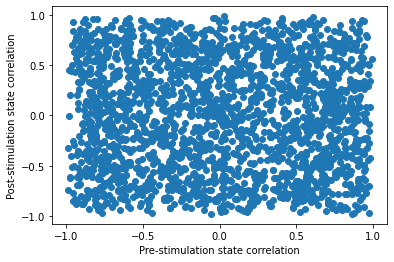

In [10]:
plt.scatter(corrind, corrind2)
plt.rcParams.update({'font.size': 14})
plt.xticks([-1, -0.5, 0, 0.5, 1])
plt.yticks([-1, -0.5, 0, 0.5, 1])
plt.xlabel('Pre-stimulation state correlation')
plt.ylabel('Post-stimulation state correlation')
plt.show()

In [11]:
from scipy.stats import linregress
linregress(corrind, corrind2)

LinregressResult(slope=-0.0221136048267263, intercept=-0.0057075263755321055, rvalue=-0.02304639007836036, pvalue=0.27871894393668567, stderr=0.020410019174452558)

In [12]:
# Correlation of Pre and Post States
corrind3 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [13]:
# Correlation Heatmap
corrind = []
corrind2 = []
for num in np.arange(n):
    for num2 in np.arange(n):
        if(num%2==0 and num2%2==0):
            corrind.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])
        elif(num%2==1 and num2%2==1):
            corrind2.append(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1])

In [14]:
print(n)

135


In [15]:
corrmat = np.asarray(corrind).reshape((int(n/2)+1,int(n/2)+1))
corrmat2 = np.asarray(corrind2).reshape((int(n/2),int(n/2)))

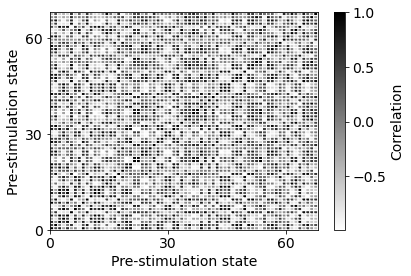

In [16]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
plt.rcParams.update({'font.size': 14})
plt.xlabel('Pre-stimulation state')
plt.ylabel('Pre-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
#plt.title('Heatmap of Pre-stimulation Radial Profile Correlation')
fig.colorbar(im, label='Correlation')
plt.show()

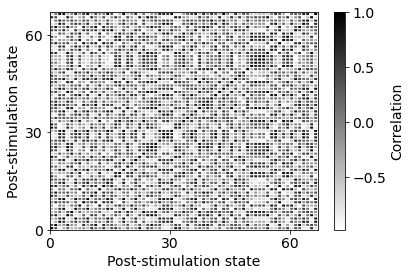

In [17]:
fig, ax = plt.subplots()
im = ax.pcolormesh(corrmat2, cmap=cm.binary, edgecolors='white', linewidths=1, antialiased=True)
fig.colorbar(im, label='Correlation')
#plt.title('Heatmap of Post-stimulation Radial Profile Correlation')
plt.xlabel('Post-stimulation state')
plt.ylabel('Post-stimulation state')
plt.xticks([0,30,60])
plt.yticks([0,30,60])
plt.show()

In [18]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    print('Image '+str(num))
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            print(str(num2)+': '+str(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]))
            corr.append(num2)
            if(num<134 and num2<134):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2==0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

Image 0
16: 0.9752169055492448
40: 0.9139946434672895
84: 0.9100206260960891
114: 0.918378772561898
Image 1
Image 2
64: 0.9664768761492046
94: 0.9574862183750571
100: 0.9029929230947032
112: 0.9439591507933157
Image 3
Image 4
8: 0.9669159097630204
22: 0.900626427562848
24: 0.9156300894577623
38: 0.9411885976015708
126: 0.909314745404485
Image 5
87: 0.9087417931689278
133: 0.903358075092131
Image 6
12: 0.9287806019759345
20: 0.9072534680218929
58: 0.9058432652155041
90: 0.9042027225717912
Image 7
13: 0.9543634985146106
19: 0.964294193686387
29: 0.9052867927805811
37: 0.9462625620575588
61: 0.9847698450685629
73: 0.9226992749849344
Image 8
22: 0.967341297063653
24: 0.9278266182026543
38: 0.9216153512185707
Image 9
51: 0.9472673144731724
Image 10
78: 0.9142656747381804
92: 0.9363727462002663
102: 0.9584572451572564
128: 0.9109262678714235
Image 11
Image 12
98: 0.9386328157446322
Image 13
19: 0.9363675339187476
29: 0.9151991348007471
37: 0.9345302692275204
61: 0.9540353630200006
Image 14
3

In [19]:
numpostcorr = 0
contdepmeans = []
contextdependent = []
for num in np.arange(n):
    corr = []
    precorr = []
    for num2 in np.arange(num+1, n):
        if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
            corr.append(num2)
            if(num>0 and num2>0 and num%2==1):
                precorr.append(np.corrcoef(lfpradprof[num+1], lfpradprof[num2+1])[0, 1])
    if(num%2!=0):
        if(len(corr)==0):
            contextdependent.append(-1)
        else:
            numpostcorr = numpostcorr+1
            nprecorr = len(np.argwhere(np.asarray(precorr)>0))
            contdepmeans.append(np.mean(precorr))
            contextdependent.append(nprecorr/len(corr))

In [20]:
numpostcorr

30

In [21]:
num/2

67.0

In [22]:
contextdependent

[-1,
 -1,
 0.5,
 0.5,
 1.0,
 -1,
 0.5,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 -1,
 -1,
 0.0,
 1.0,
 1.0,
 0.0,
 0.5,
 0.3333333333333333,
 -1,
 -1,
 -1,
 -1,
 0.5,
 -1,
 -1,
 0.5,
 0.5,
 0.5,
 0.0,
 0.5,
 -1,
 0.5,
 -1,
 0.0,
 0.0,
 0.5,
 -1,
 -1,
 1.0,
 -1,
 -1,
 0.0,
 -1,
 1.0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 0.0,
 -1,
 1.0,
 0.0,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [23]:
len(np.argwhere(np.asarray(contextdependent)>0.7))

6

In [24]:
#Repeat but shuffle prestates
shuffledarr = 2*np.arange(n/2).astype(int)
#Permutation
ncdpermutation = []
ncdpermmean = []
for perm in range(1000):
    np.random.shuffle(shuffledarr)
    numpostcorr = 0
    contdepmeans = []
    contextdependent = []
    for num in np.arange(n):
        corr = []
        precorr = []
        for num2 in np.arange(num+1, n):
            if(np.corrcoef(lfpradprof[num], lfpradprof[num2])[0, 1]>0.9 and num%2==num2%2):
                corr.append(num2)
                if(num>0 and num2>0 and num%2==1):
                    precorr.append(np.corrcoef(lfpradprof[shuffledarr[(int)((num-1)/2)]], lfpradprof[shuffledarr[(int)((num2-1)/2)]])[0, 1])
        if(num%2!=0):
            if(len(corr)==0):
                contextdependent.append(-1)
            else:
                numpostcorr = numpostcorr+1
                nprecorr = len(np.argwhere(np.asarray(precorr)>0))
                contdepmeans.append(np.mean(precorr))
                contextdependent.append(nprecorr/len(corr))
    print(perm)
    ncdpermutation.append(len(np.argwhere(np.asarray(contextdependent)>0.7)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
print(np.mean(ncdpermutation))

10.793


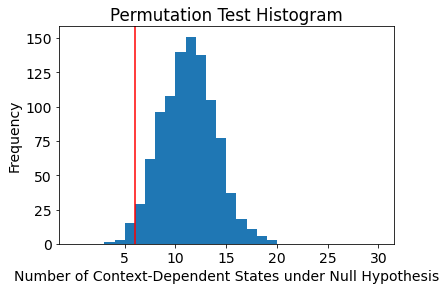

In [27]:
plt.hist(np.asarray(ncdpermutation), bins=30, range=(0,30))
plt.axvline(x=6).set_color('red')
plt.xticks([5,10,15,20,25,30])
plt.title('Permutation Test Histogram')
plt.ylabel('Frequency')
plt.xlabel('Number of Context-Dependent States under Null Hypothesis')
plt.show()

In [28]:
len(np.argwhere(np.asarray(ncdpermutation)>6))

952

In [27]:
np.std(ncdpermutation)

2.6540316501503893